In [1]:
%matplotlib

Using matplotlib backend: TkAgg


In [1]:
from common import colors, sbarlw, insetlw, savefig
from gating_util import (
    mark_time_interval,
    save_gating_params,
    load_gating_params,
    get_plot_coordinates_with_error,
)

In [2]:
import os; os.chdir(os.path.join('..', '..'))
print(os.getcwd())

/home/efharkin/projects/raphegif/raphegif


In [3]:
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns
import numpy as np

from ezephys import pltools
from ezephys.rectools import ABFLoader, Recording
from grr.CurveFit import extract_gating_data, fit_gating_curve
from grr.Tools import dashedBorder 
from grr.cell_class import preprocess_recording, max_normalize_channel

In [4]:
DATA_PATH = os.path.join('data', 'processed', 'gating')
IMG_PATH = None#os.path.join('figs', 'ims', 'writeup', 'fig1')
NOTEBOOK_PATH = os.path.join('figs', 'scripts')

plt.style.use(os.path.join(NOTEBOOK_PATH, 'publication_figure_style.dms'))

In [5]:
rec_index = pd.read_csv(
    os.path.join(os.getenv('DATA_PATH'), 'raw', '5HT', 'heated_gating', 'index.csv')
)
rec_index

,cell_id,membrane_resistance_megaohm,membrane_capacitance_picofarad,access_resistance_megaohm,holding_current_picoamp,filename,comment,ttx_micromolar,nicl2_millimolar,heteropodatoxin2_nanomolar,ammtx3_micromolar,command_scaling,include
0,DRN1065,1000,50,40,NaN,22224042.abf,Unclamped action potentials? 10mV step increme...,0.5,0,0,0,1,False
1,DRN1066,600,80,15,NaN,22224044.abf,"10mV step increments, voltage offset 20 mV",1.0,0,0,0,1,False
2,DRN1067,1000,50,22,NaN,22224046.abf,10mV step increments,1.0,0,0,0,1,True
3,DRN1067,1000,50,22,NaN,22224047.abf,10mV step increments,1.0,10,0,0,1,True
4,DRN1116,500,70,19,NaN,22407000.abf,5mV step increments,1.0,0,0,0,20,True
5,DRN1118,300,60,10,NaN,22407001.abf,5mV step increments,1.0,0,0,0,20,True
6,DRN1119,500,40,14,NaN,22407002.abf,5mV step increments,1.0,0,0,0,20,True
7,DRN1119,500,40,14,NaN,22407004.abf,5mV step increments,1.0,0,500,0,20,True
8,DRN1119,500,40,14,NaN,22407006.abf,5mV step increments,1.0,0,500,1,20,True
9,DRN1120,300,30,5,NaN,22407008.abf,5mV step increments,1.0,0,0,0,20,True


In [6]:
ACCESS_RESISTANCE_CUTOFF = 20
INCLUSION_QUERY = (
    'access_resistance_megaohm <= @ACCESS_RESISTANCE_CUTOFF '
    'and nicl2_millimolar == 0 '
    'and heteropodatoxin2_nanomolar == 0 '
    'and ammtx3_micromolar == 0 '
    'and include'
)
gating_rec_index = rec_index.query(INCLUSION_QUERY)

CURRENT_CHANNEL, VOLTAGE_CHANNEL = 0, 1

l = ABFLoader()
gating = []
for _, row in gating_rec_index.iterrows():
    rec = l.load(
        os.path.join(
            os.getenv('DATA_PATH'),
            'raw',
            '5HT',
            'heated_gating',
            row['filename'],
        )
    )[0]
    rec[VOLTAGE_CHANNEL, ...] /= row['command_scaling']
    gating.append(rec)

del l, rec
gating_rec_index

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


,cell_id,membrane_resistance_megaohm,membrane_capacitance_picofarad,access_resistance_megaohm,holding_current_picoamp,filename,comment,ttx_micromolar,nicl2_millimolar,heteropodatoxin2_nanomolar,ammtx3_micromolar,command_scaling,include
4,DRN1116,500,70,19,NaN,22407000.abf,5mV step increments,1.0,0,0,0,20,True
5,DRN1118,300,60,10,NaN,22407001.abf,5mV step increments,1.0,0,0,0,20,True
6,DRN1119,500,40,14,NaN,22407002.abf,5mV step increments,1.0,0,0,0,20,True
9,DRN1120,300,30,5,NaN,22407008.abf,5mV step increments,1.0,0,0,0,20,True
11,DRN1121,500,55,12,NaN,22407011.abf,5mV step increments,1.0,0,0,0,20,True
12,DRN1127,400,50,18,NaN,22422000.abf,5mV step increments,1.0,0,0,0,1,True


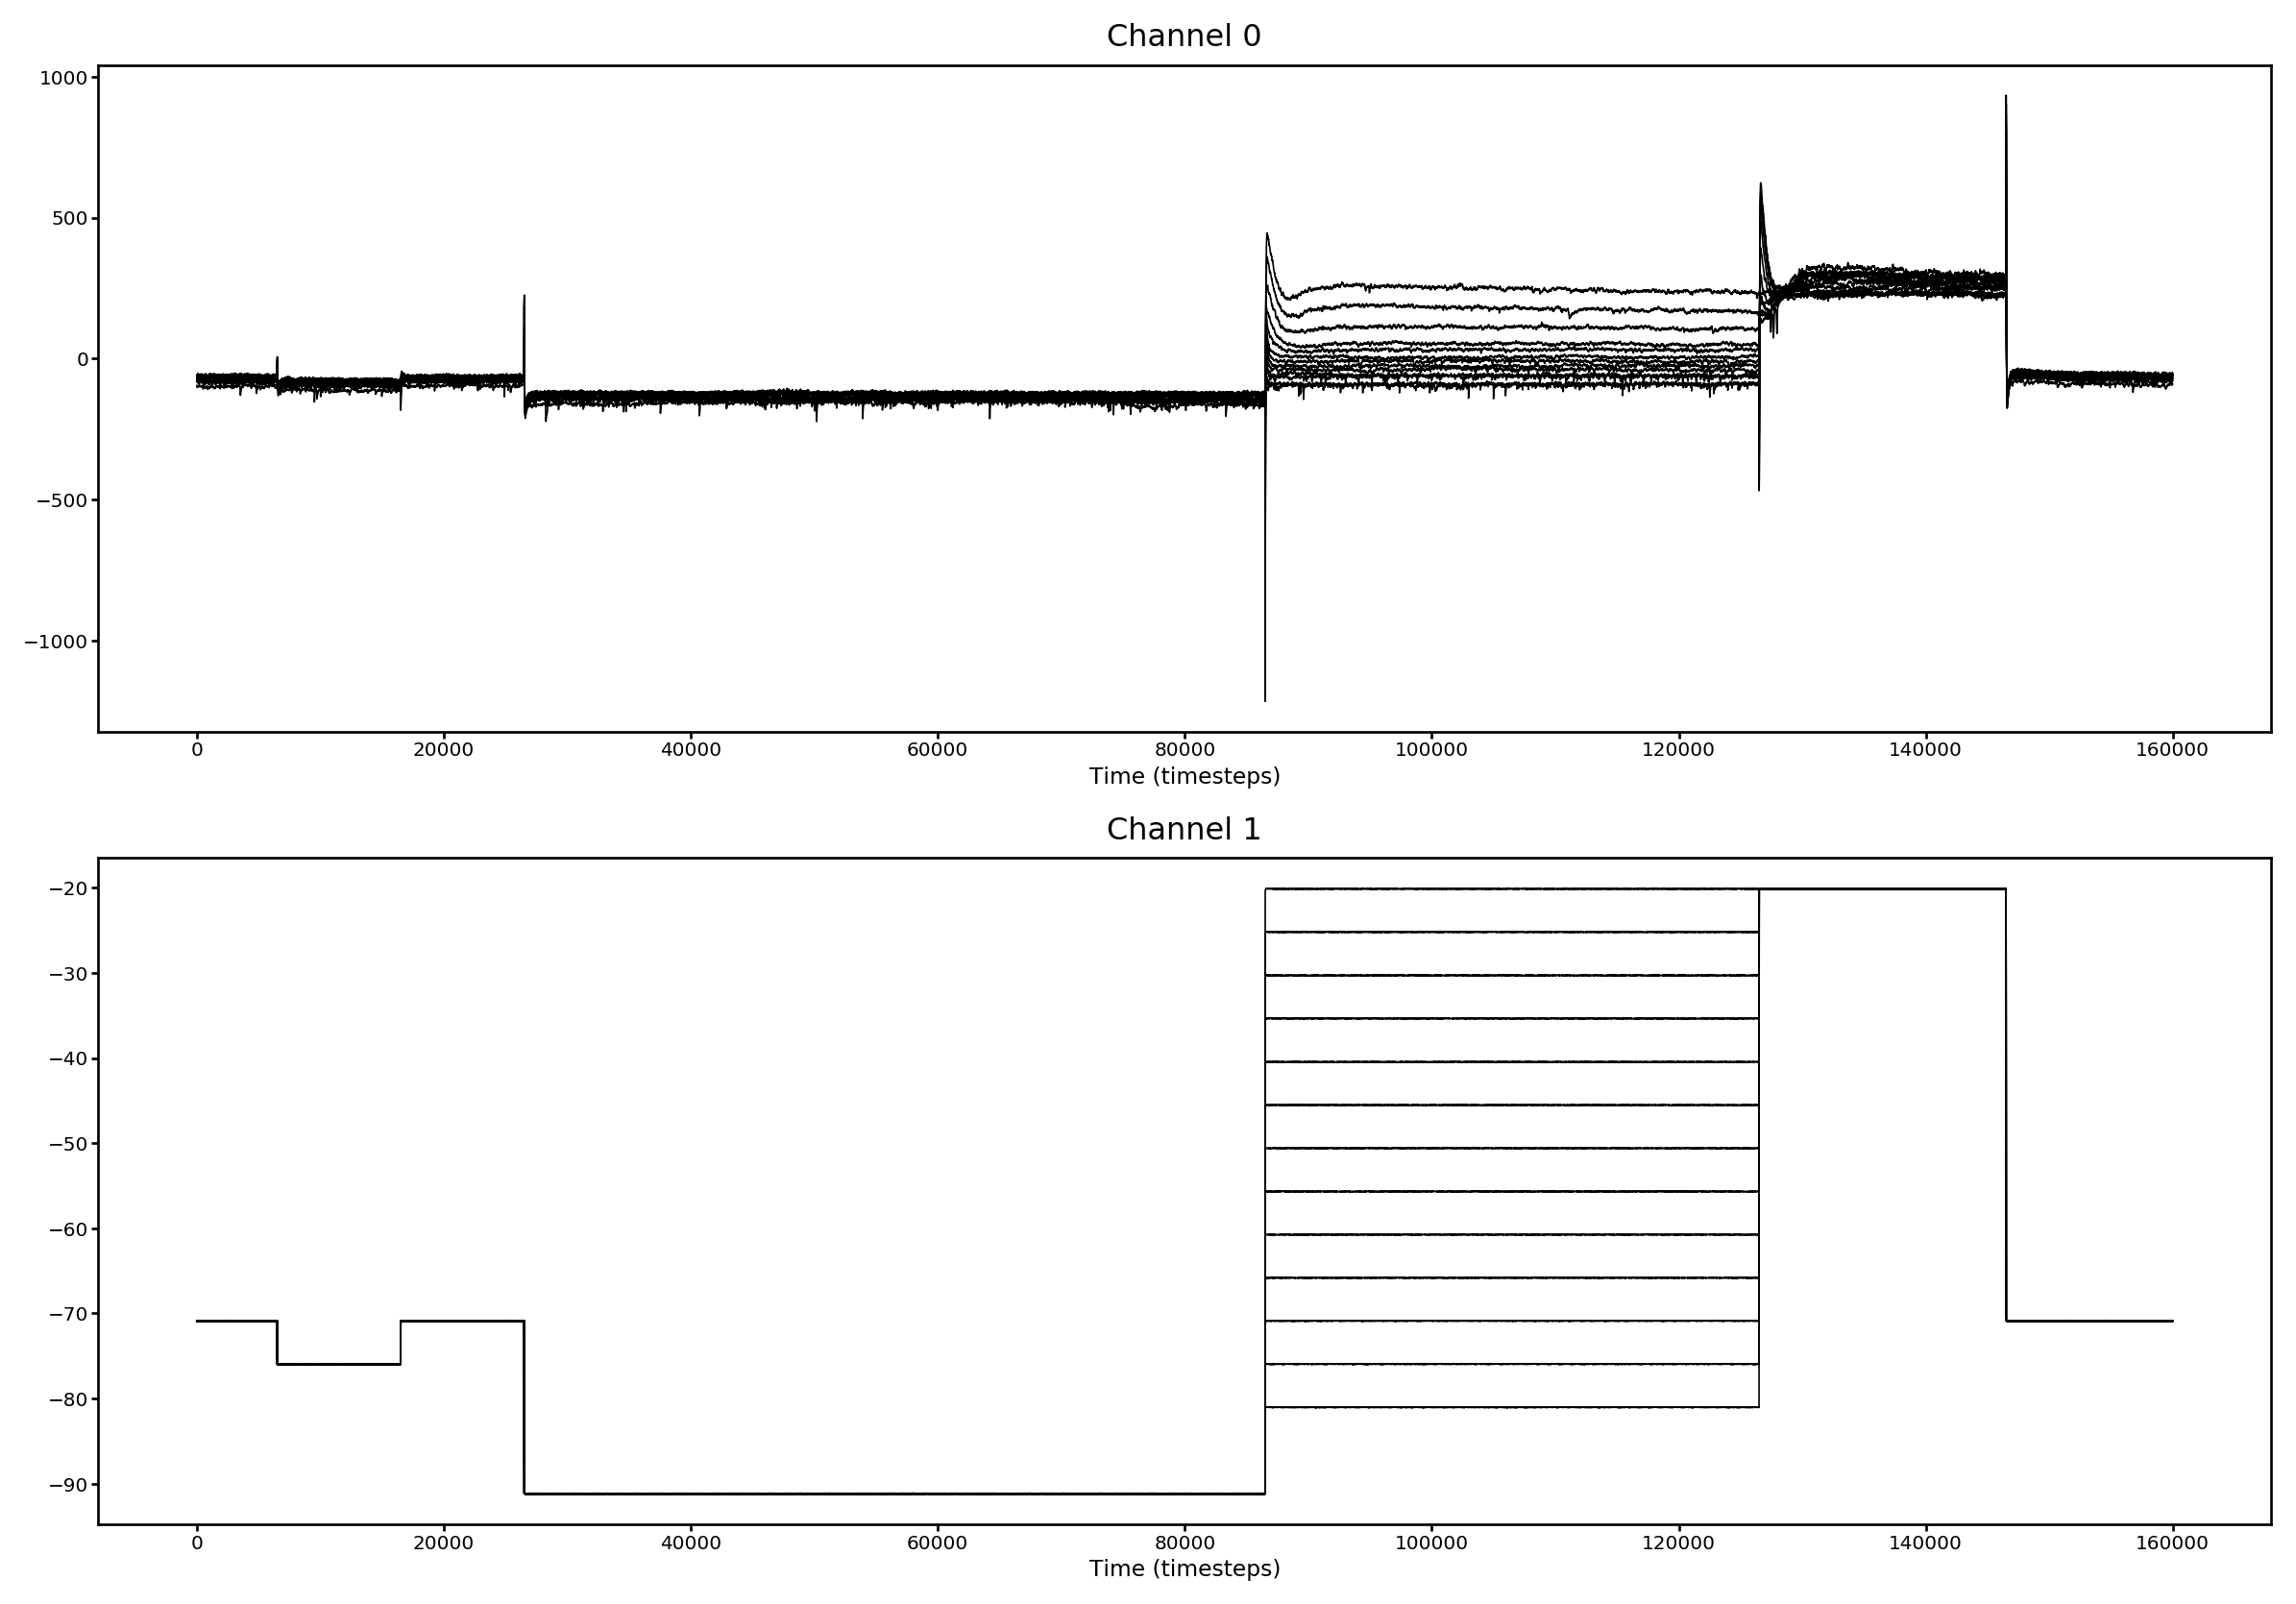

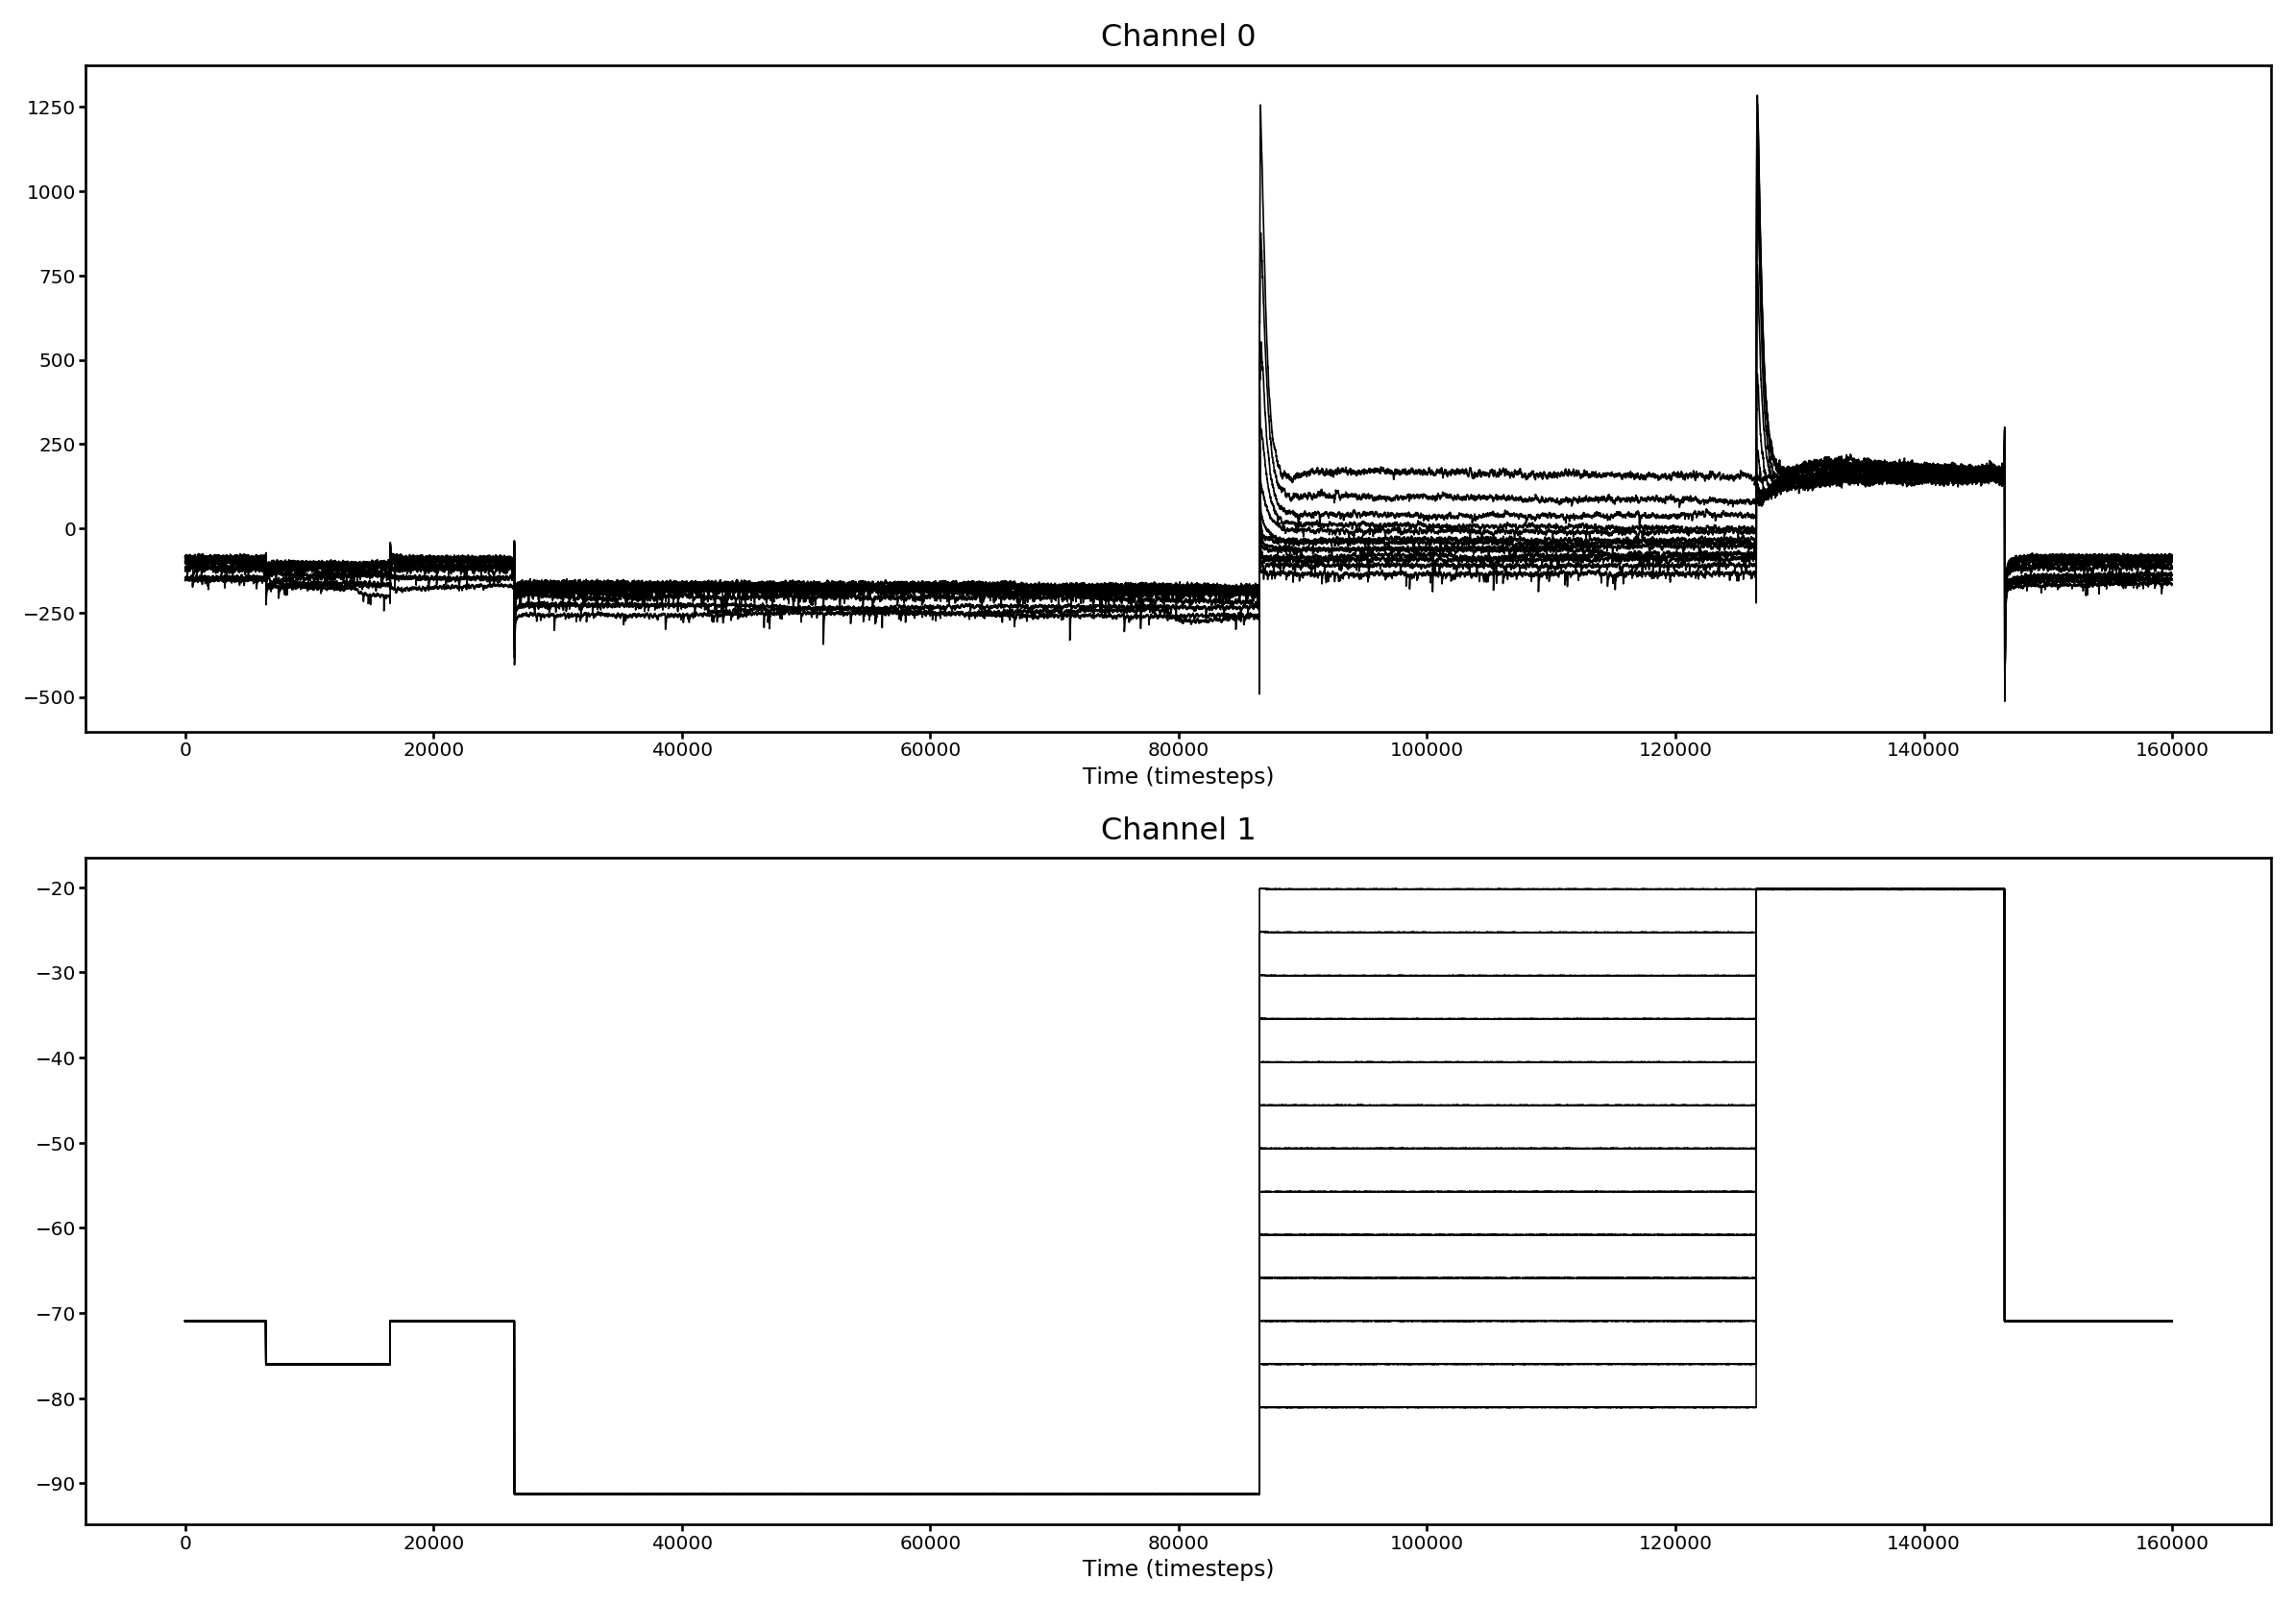

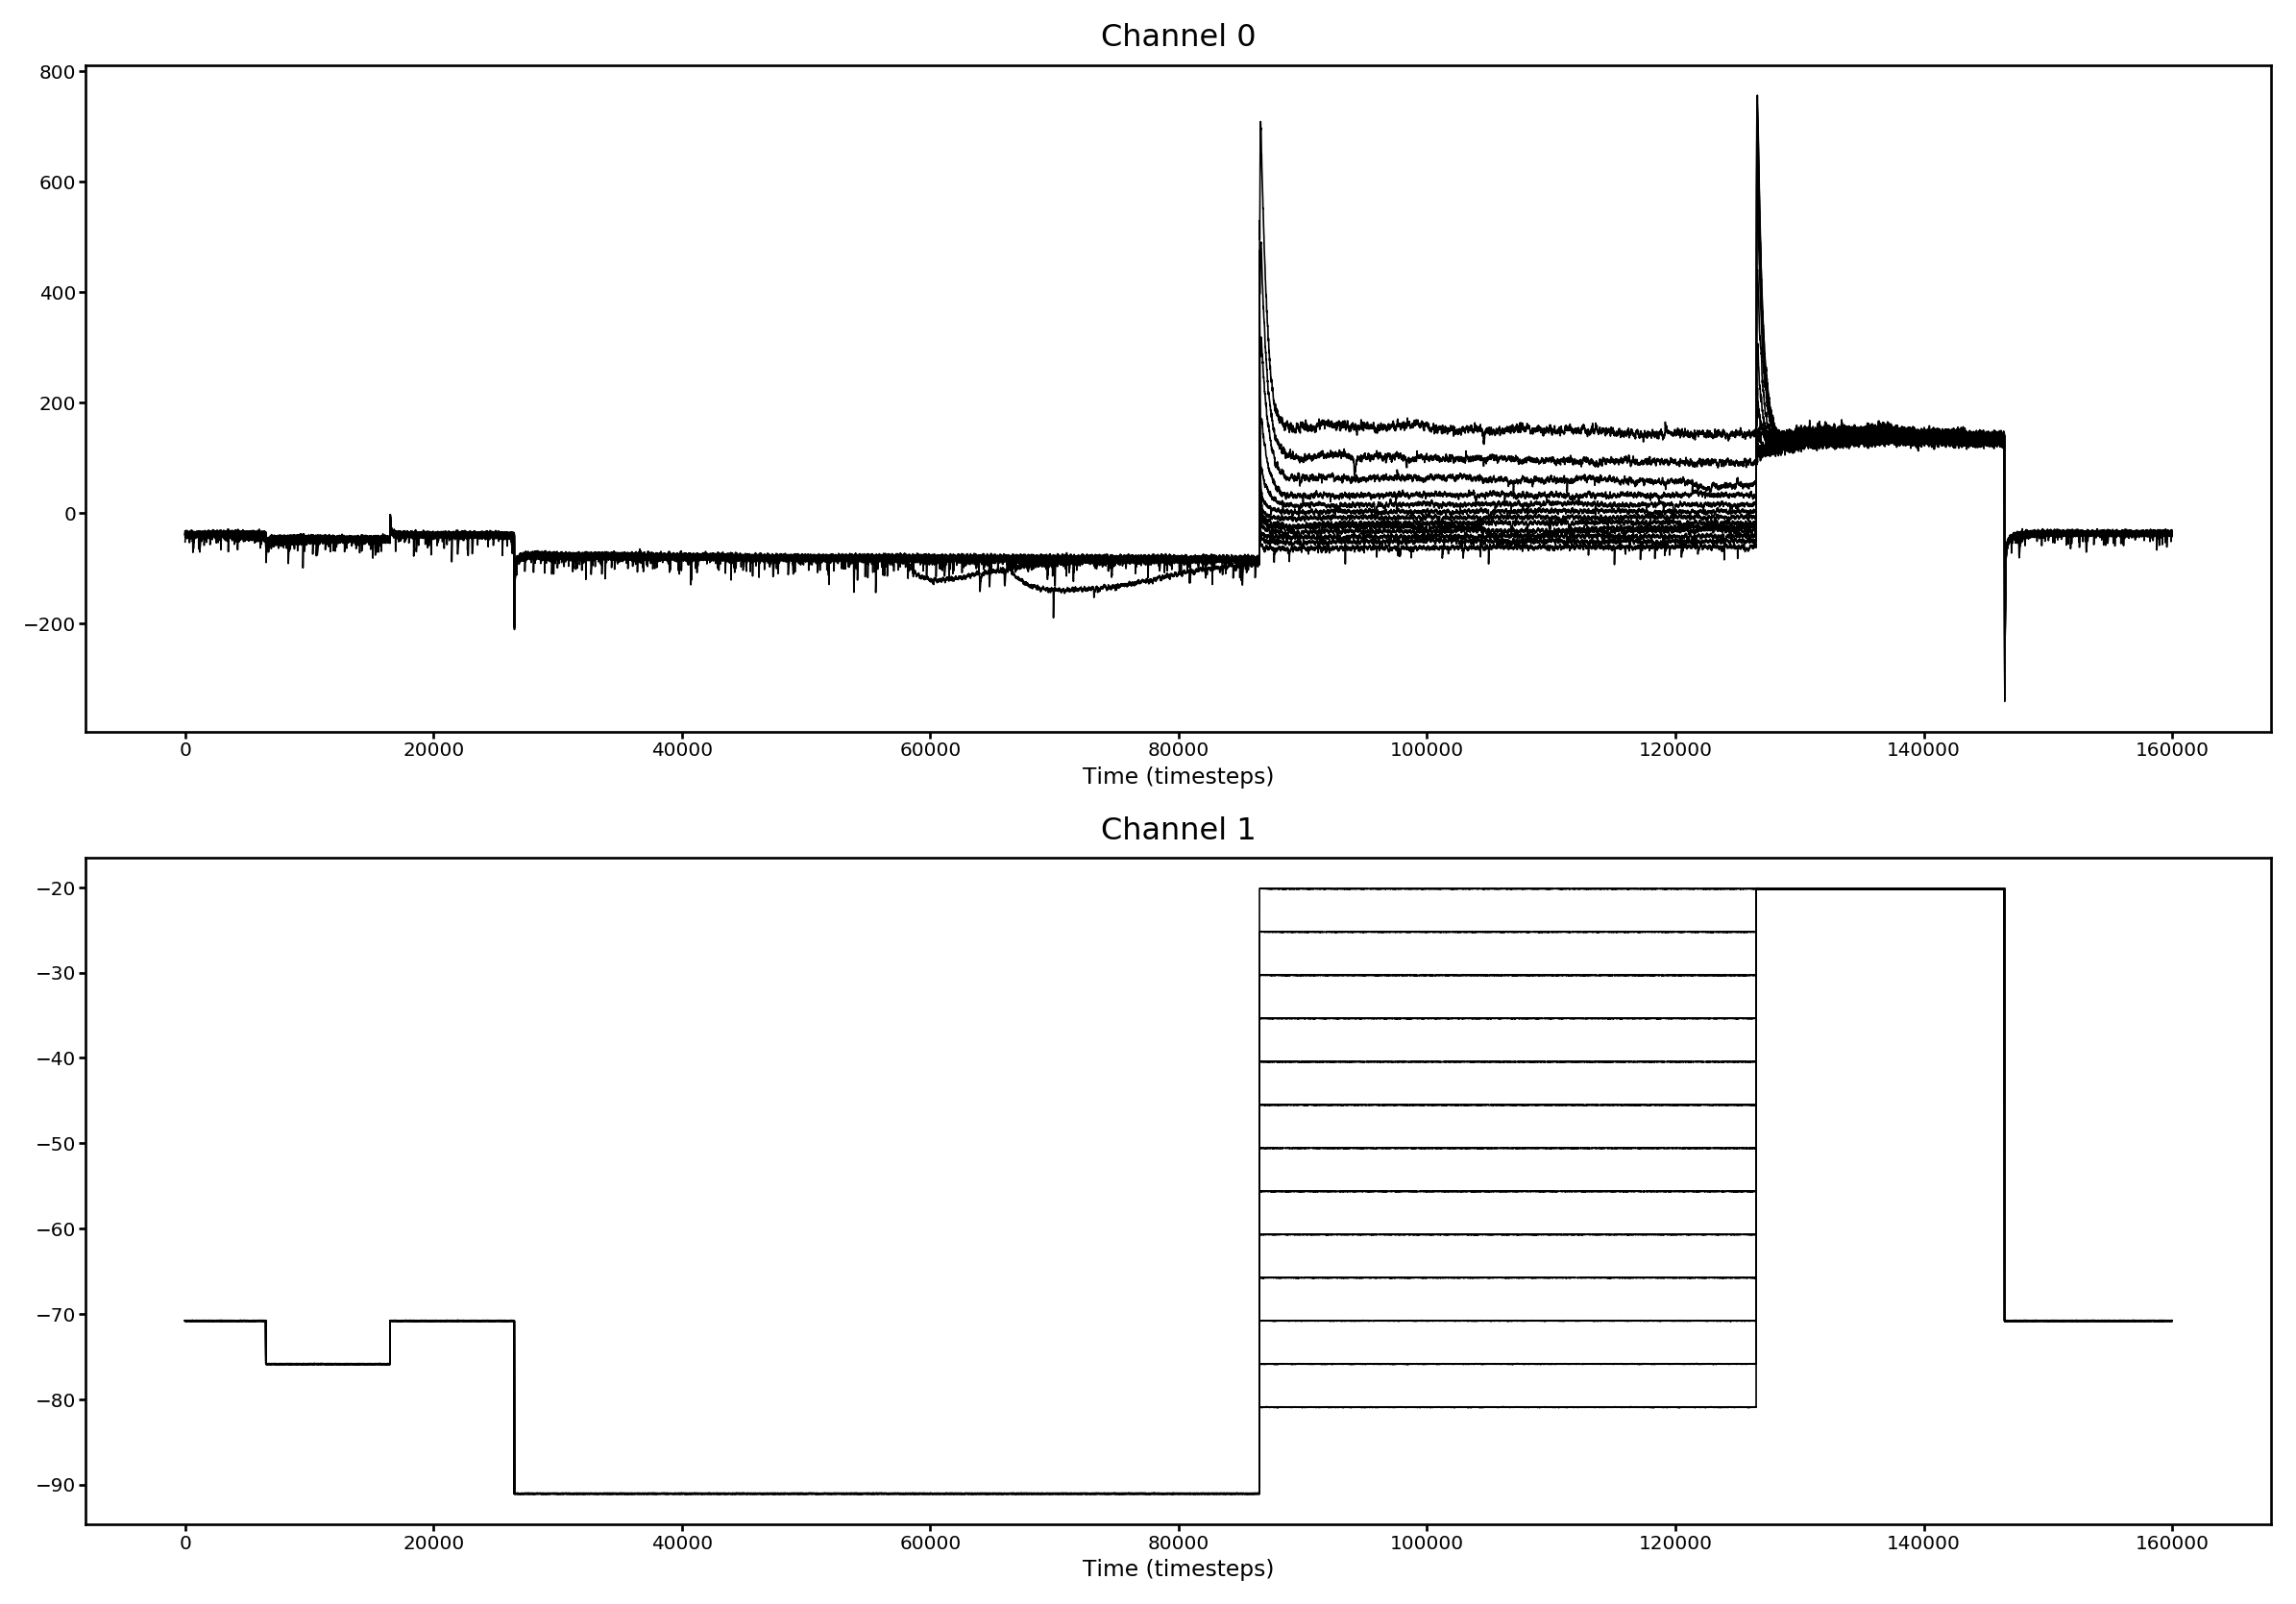

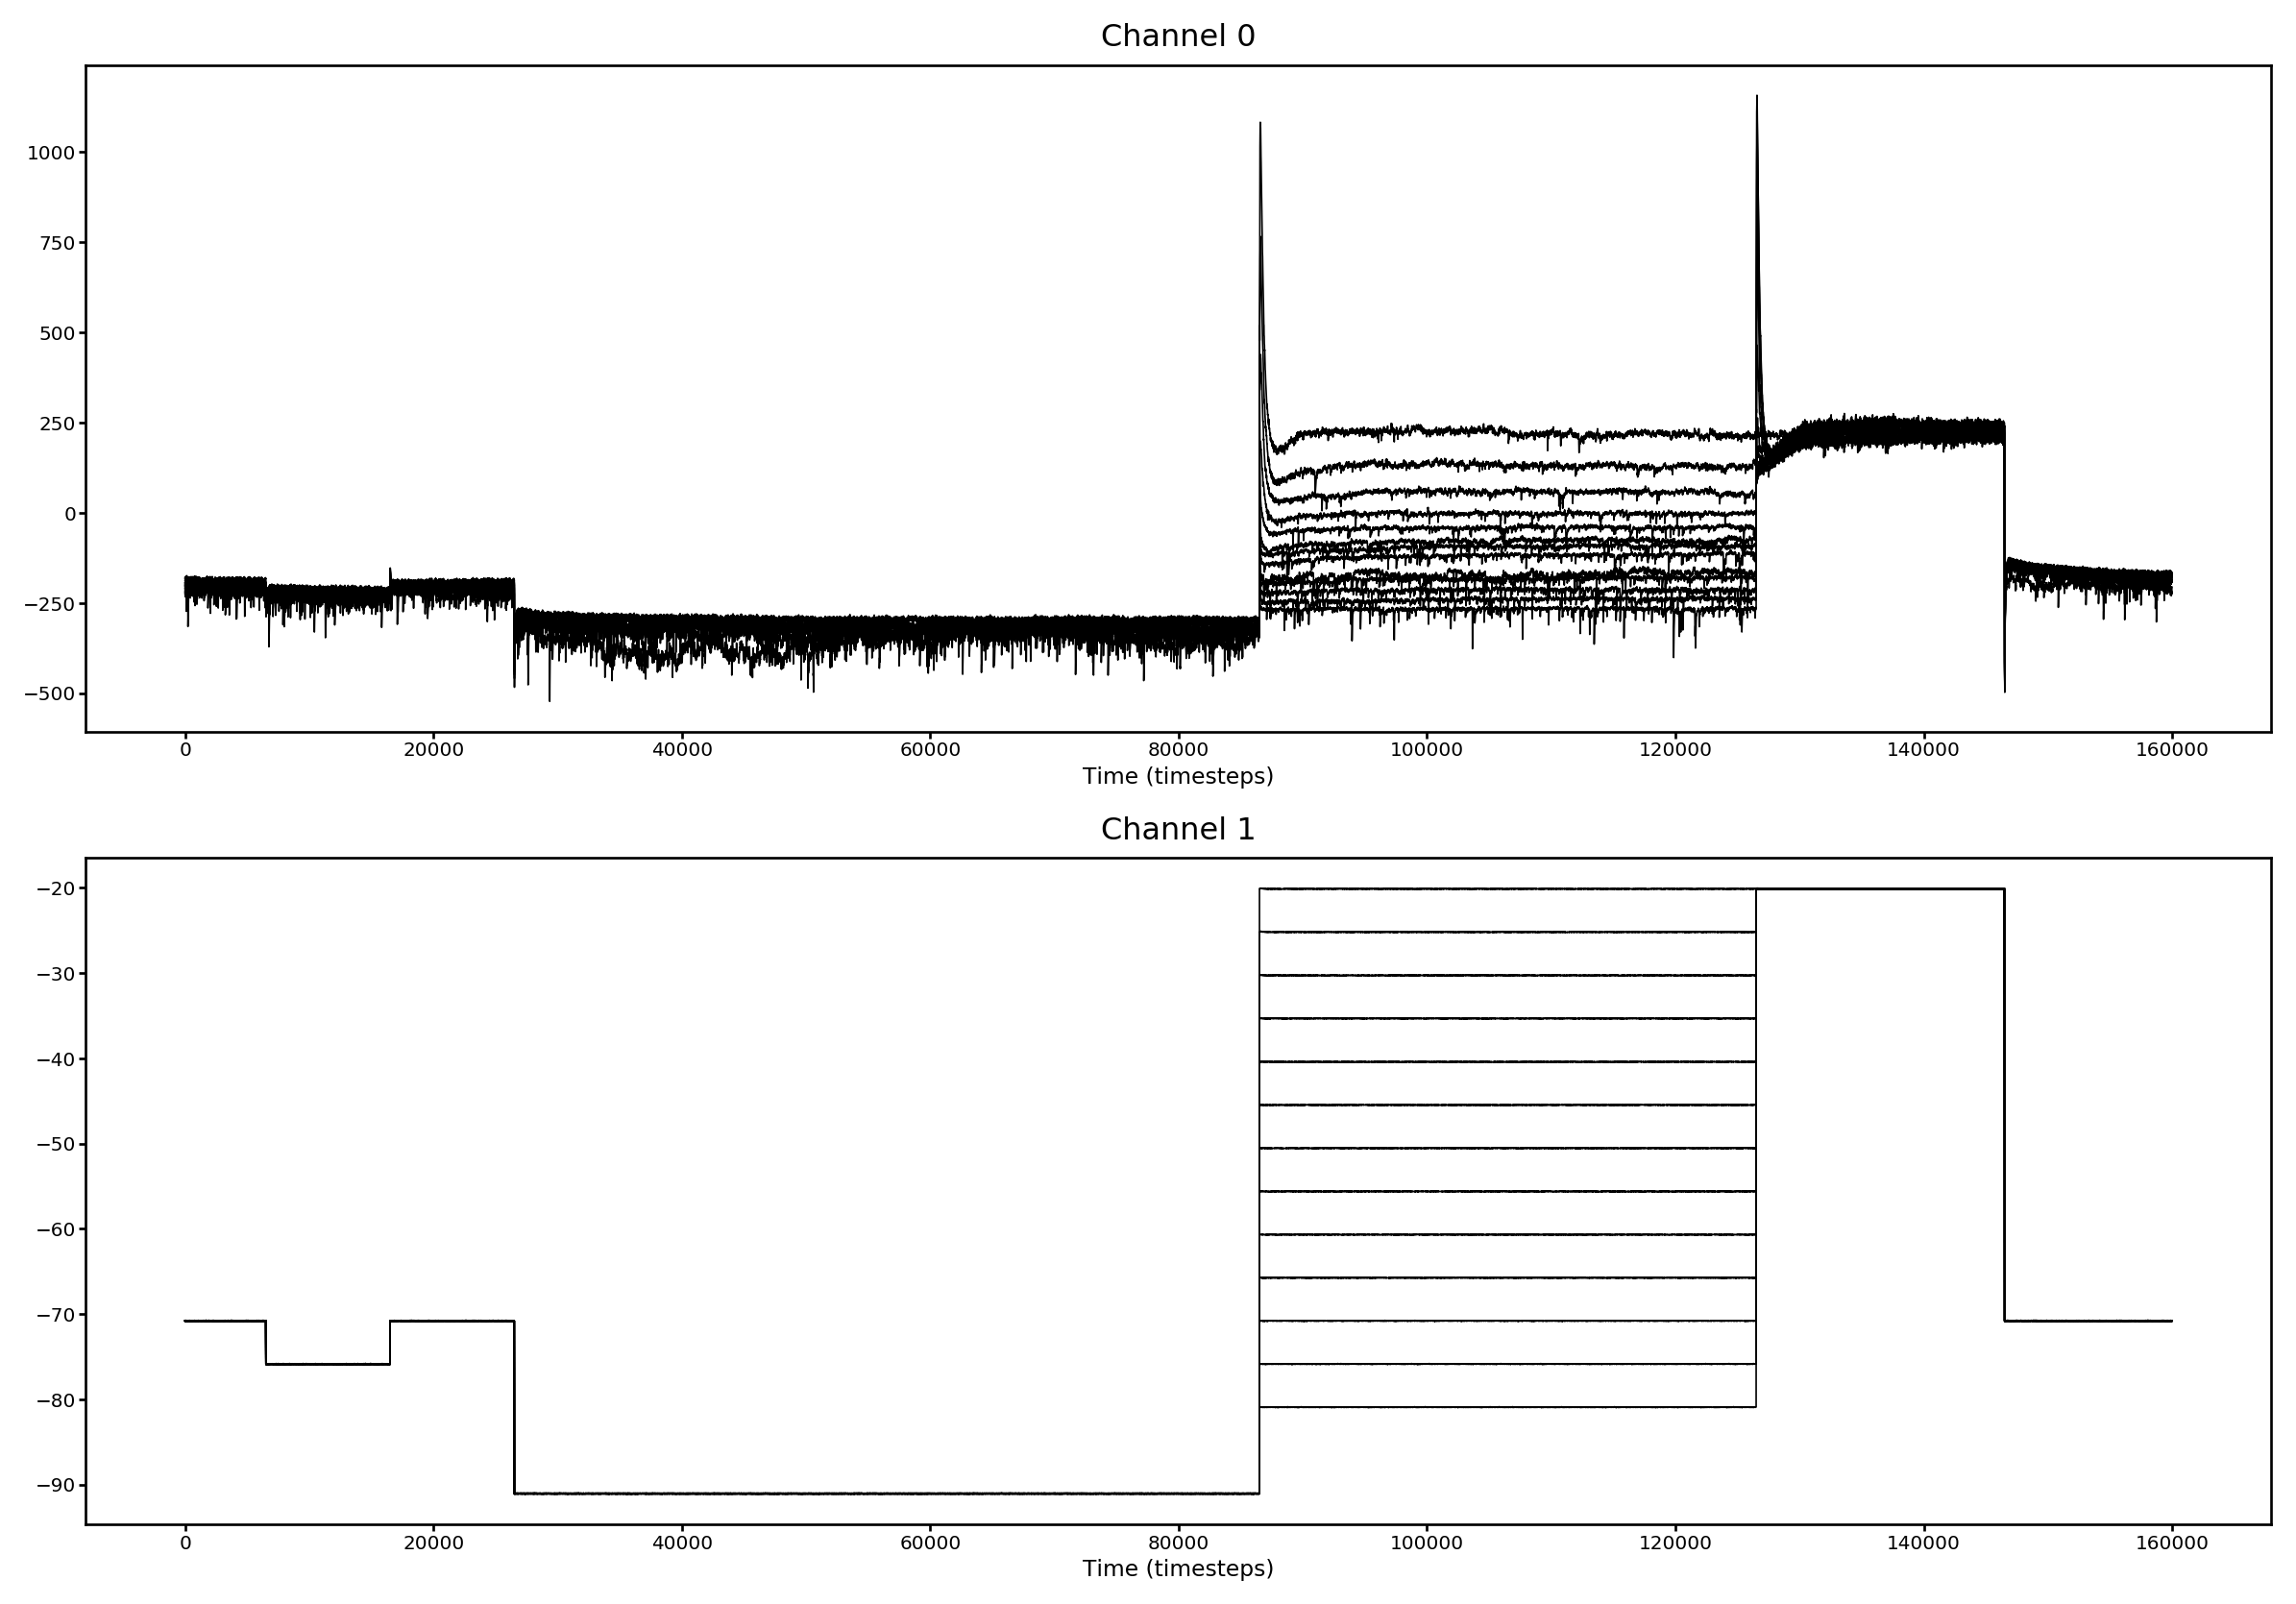

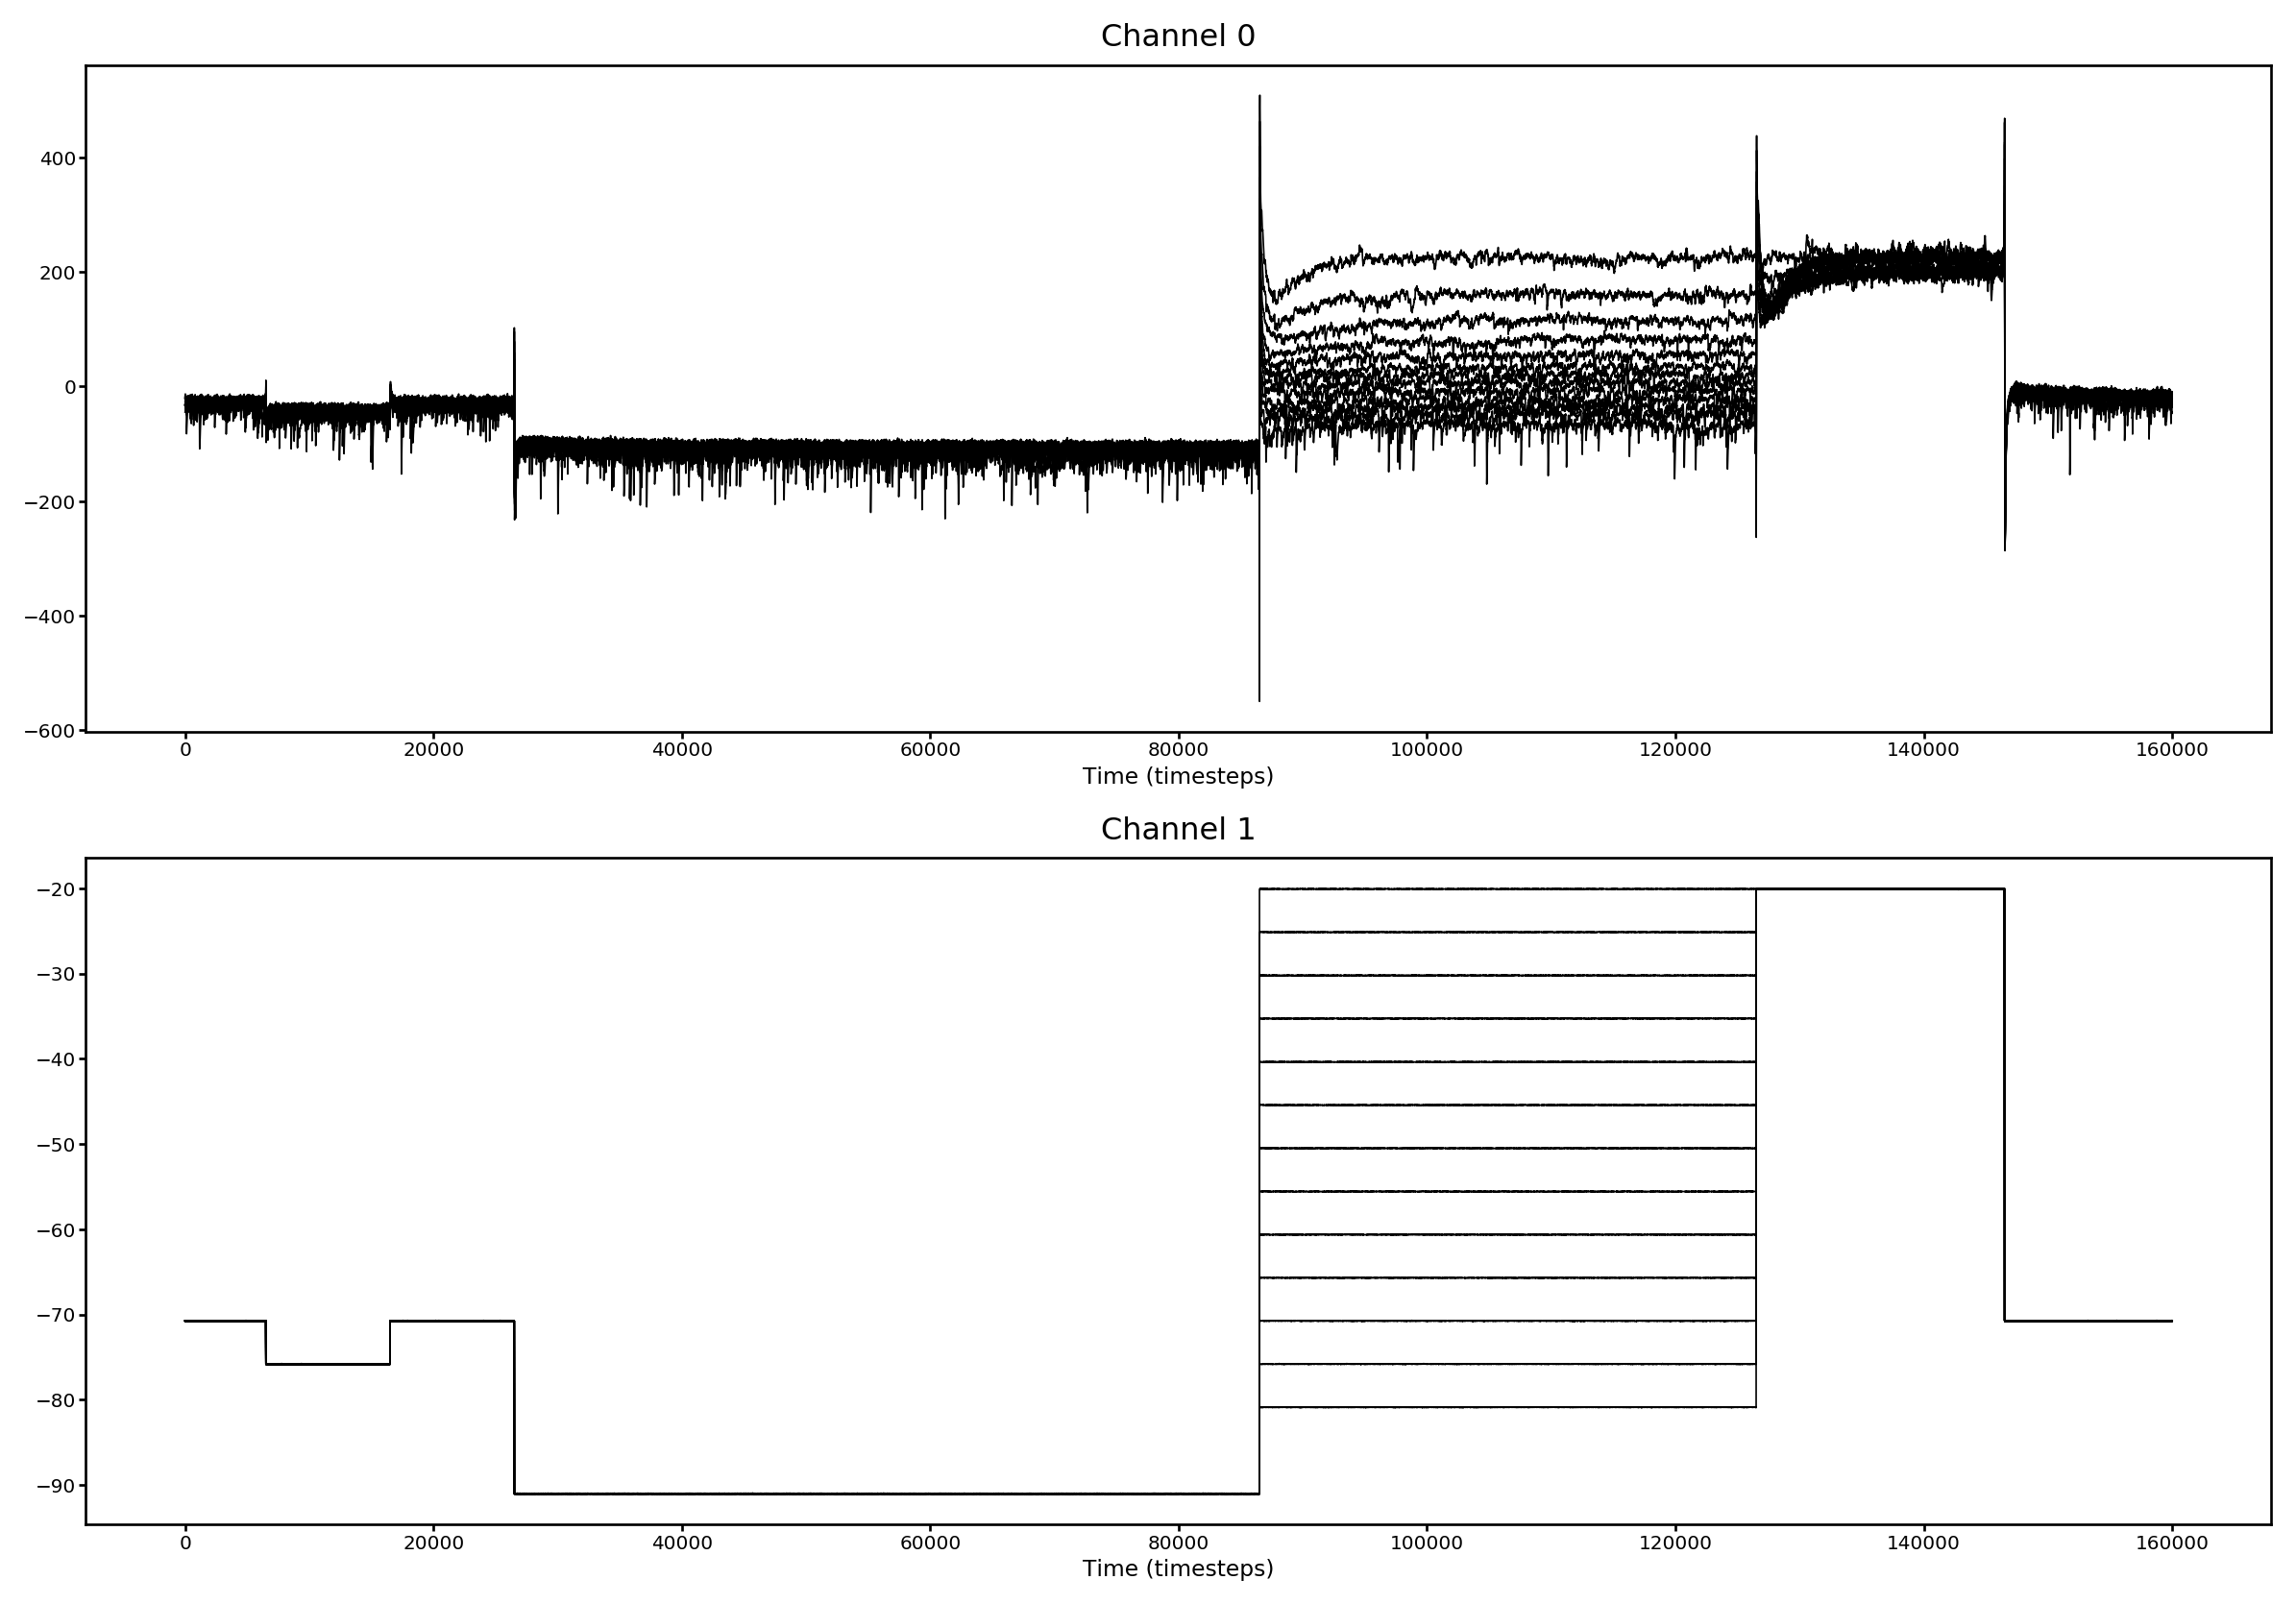

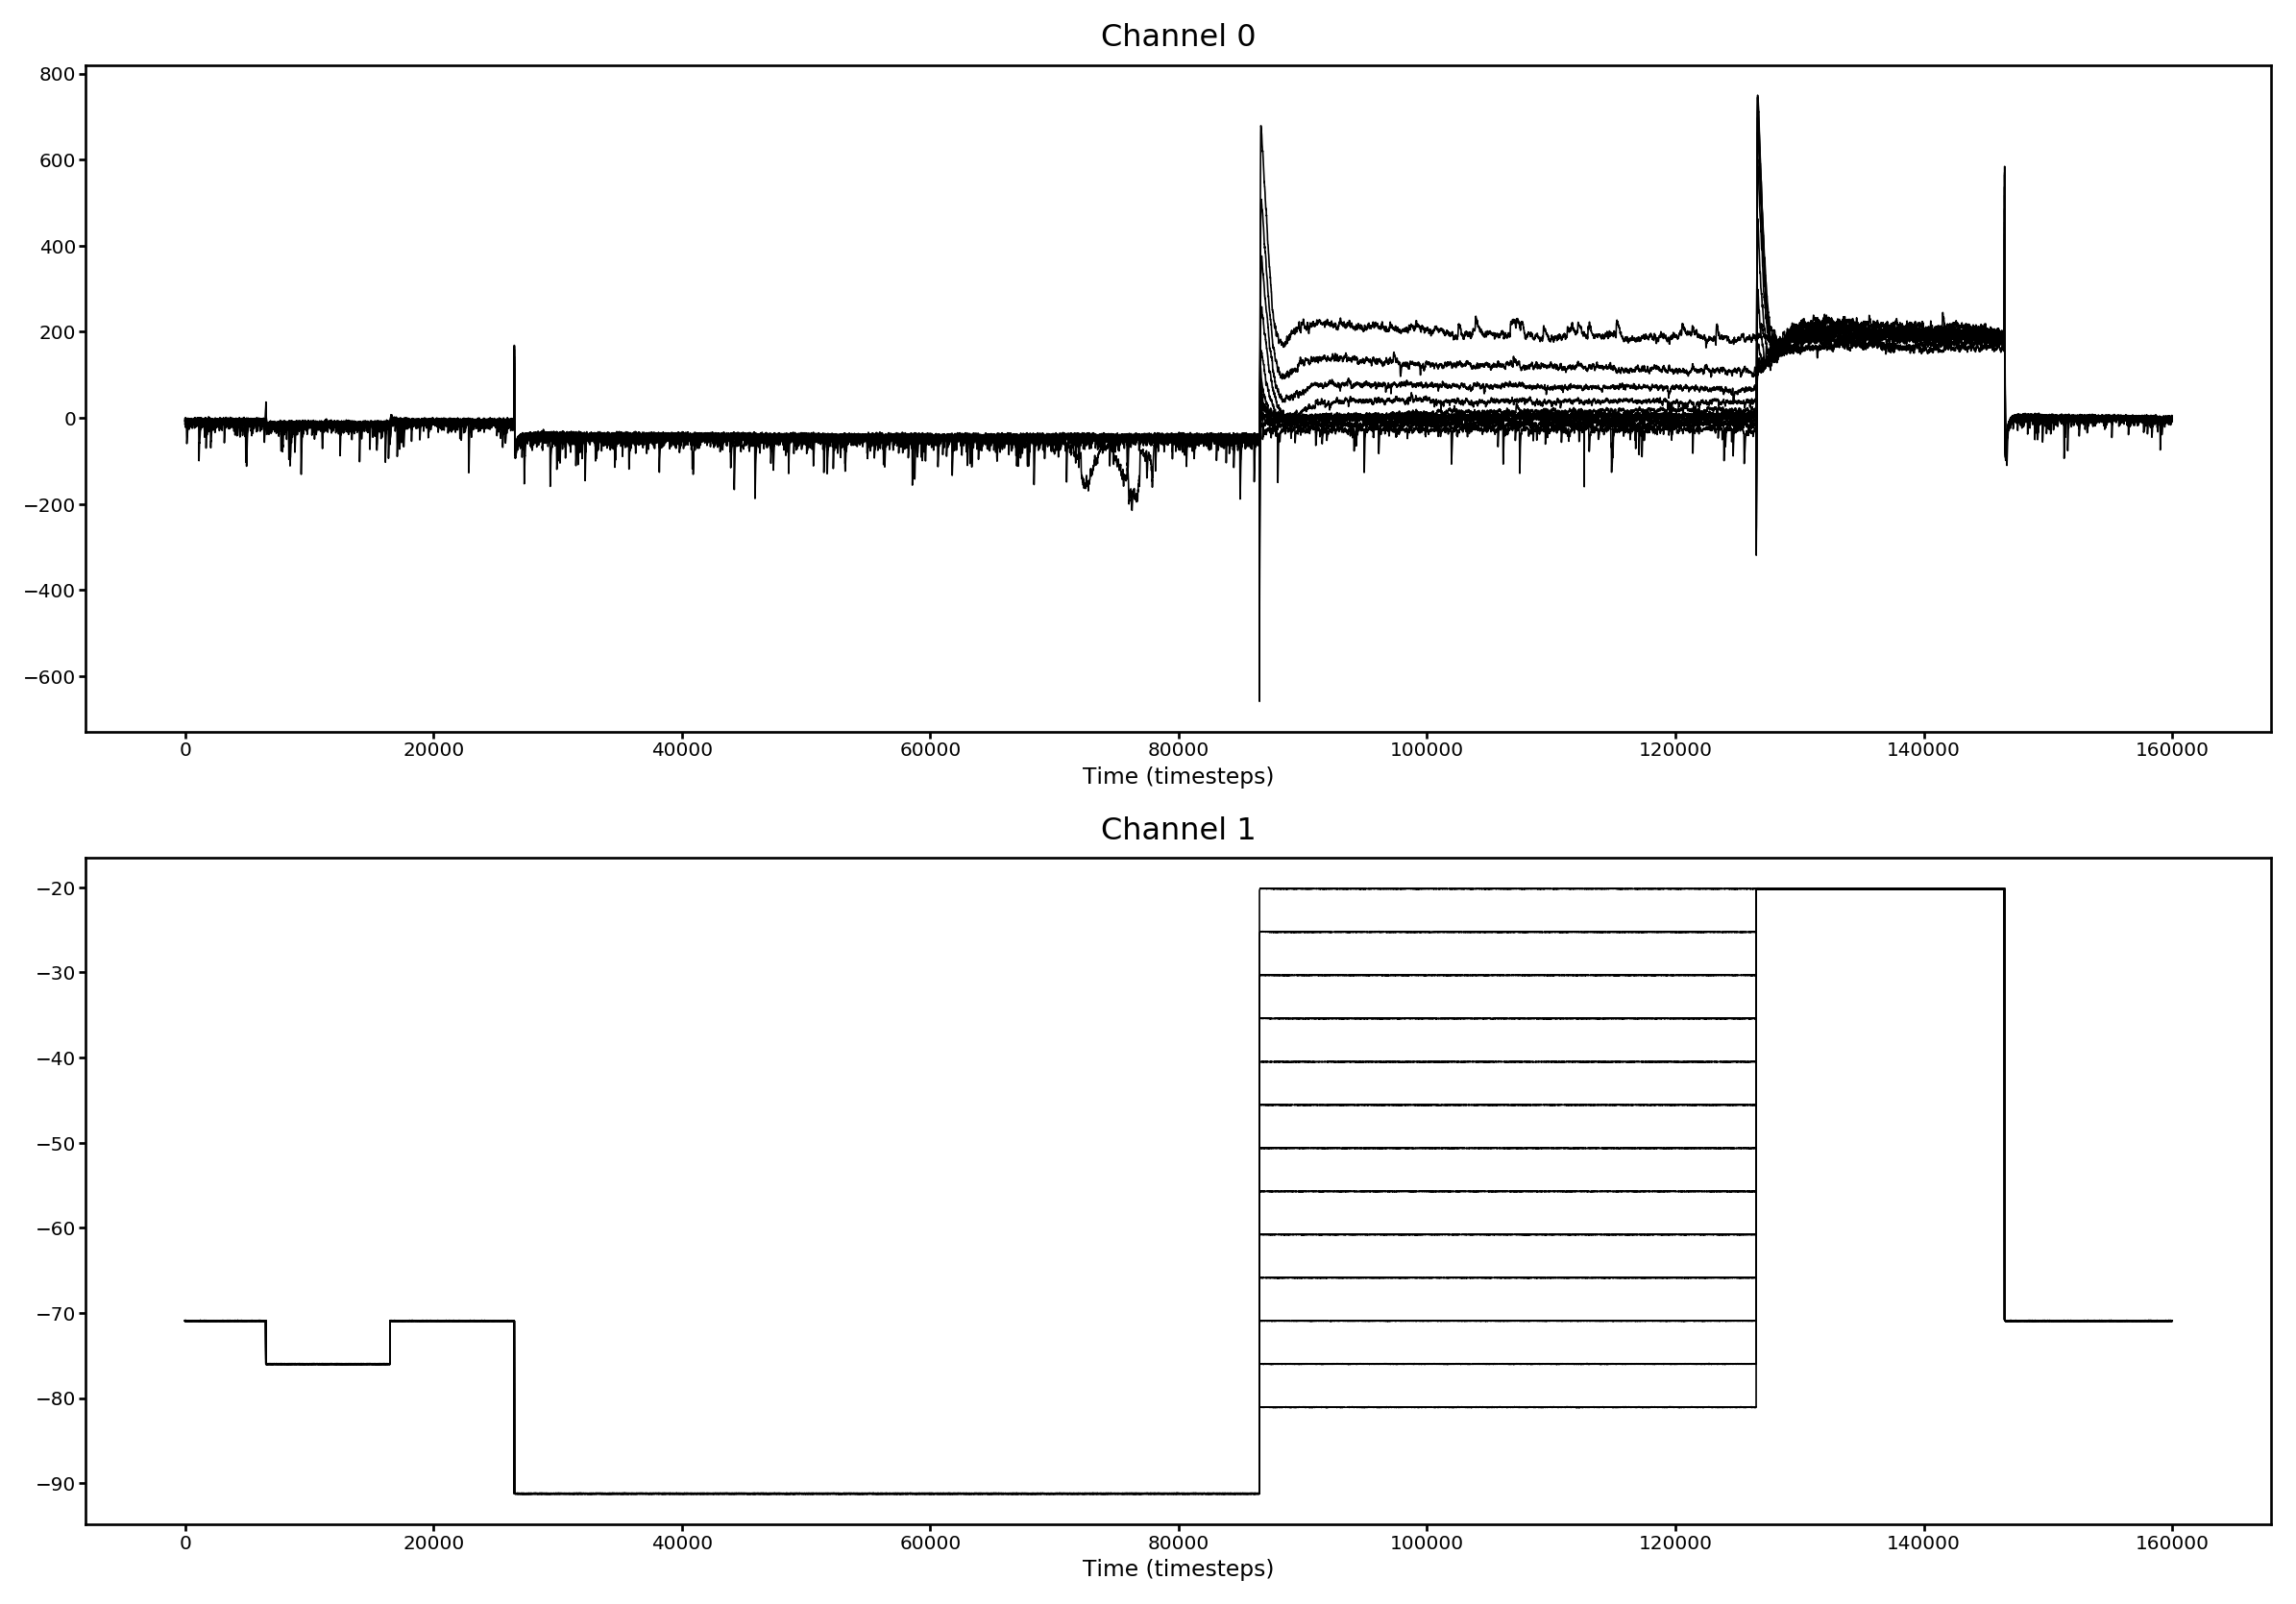

In [7]:
for r in gating:
    r.plot()

In [10]:
gating_time_windows = {
    'windows': {
        'baseline_window': (4000, 6000),
        'test_window': (14000, 16000),
        'activation_peak_window': [(86640, 86680), (86600, 86640), (86600, 86640), (86580, 86620), (86530, 86560), (86600, 86640)],
        'inactivation_peak_window': [(126600, 126640), (126580, 126620), (126580, 126620), (126560, 126600), (126600, 126640), (126600, 126640)],
        'steady_state_window': (124000, 126000),
    },
    'window_unit': 'time_step',
}

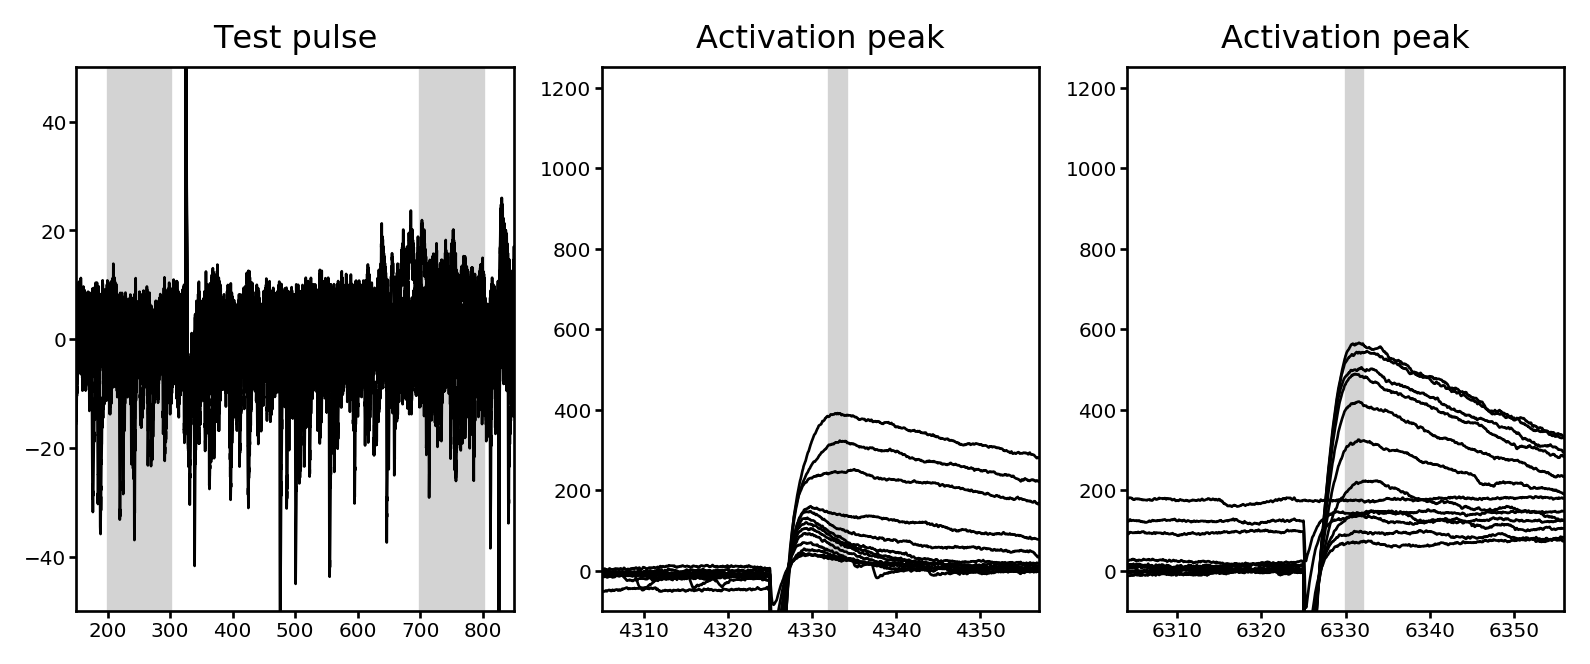

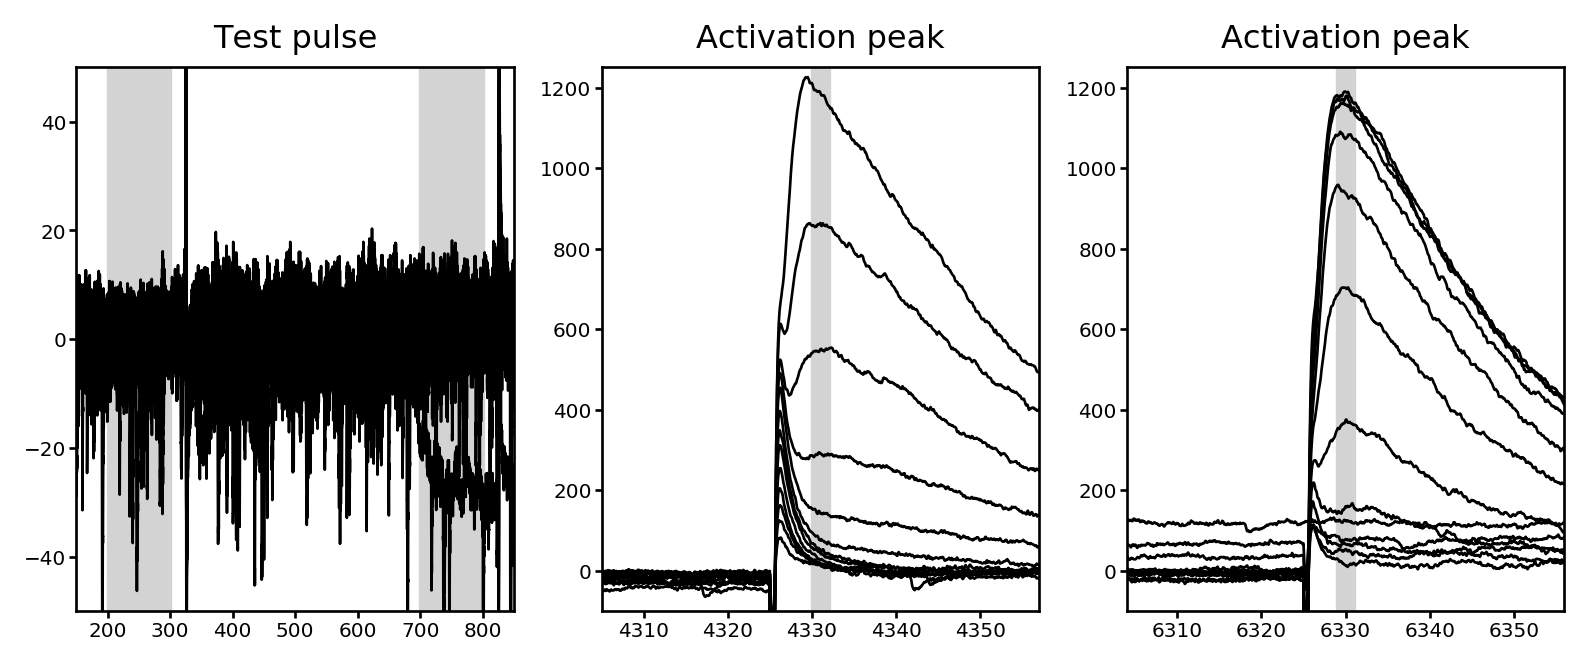

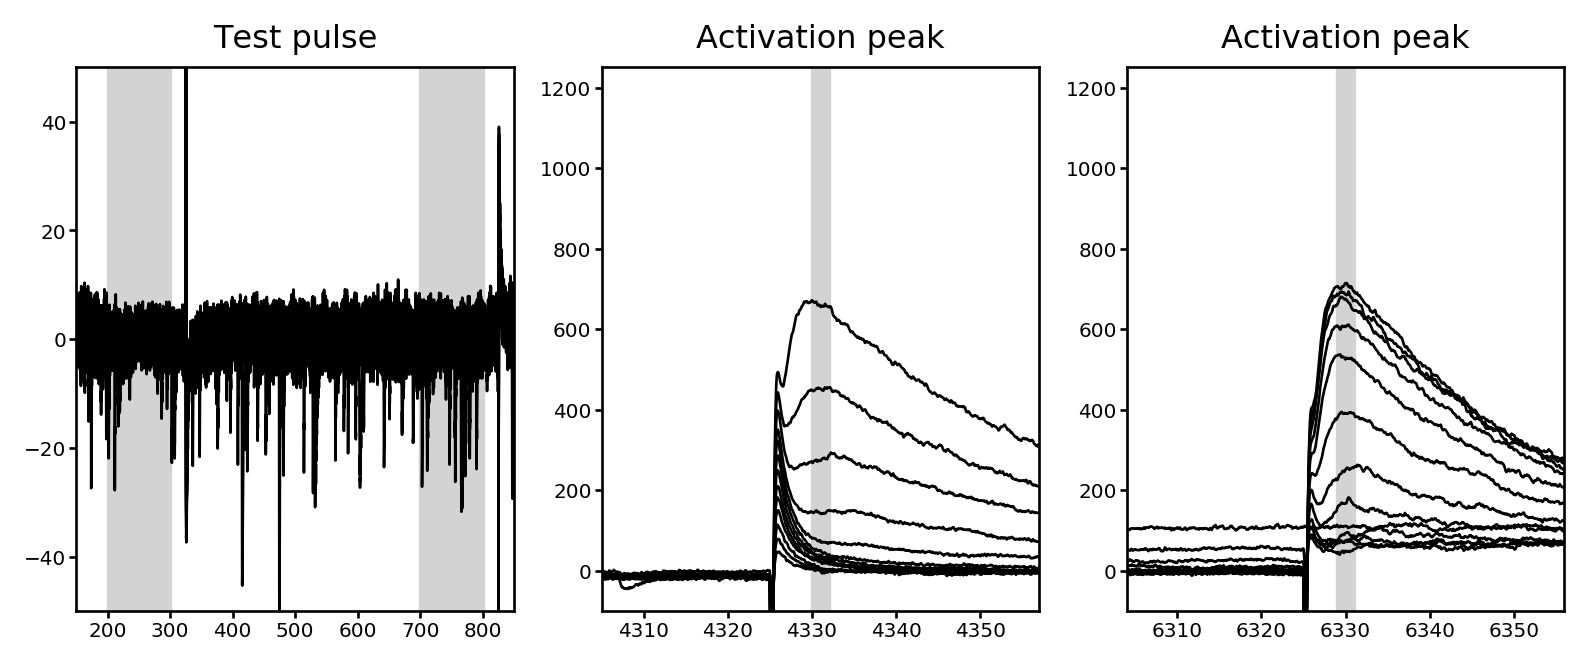

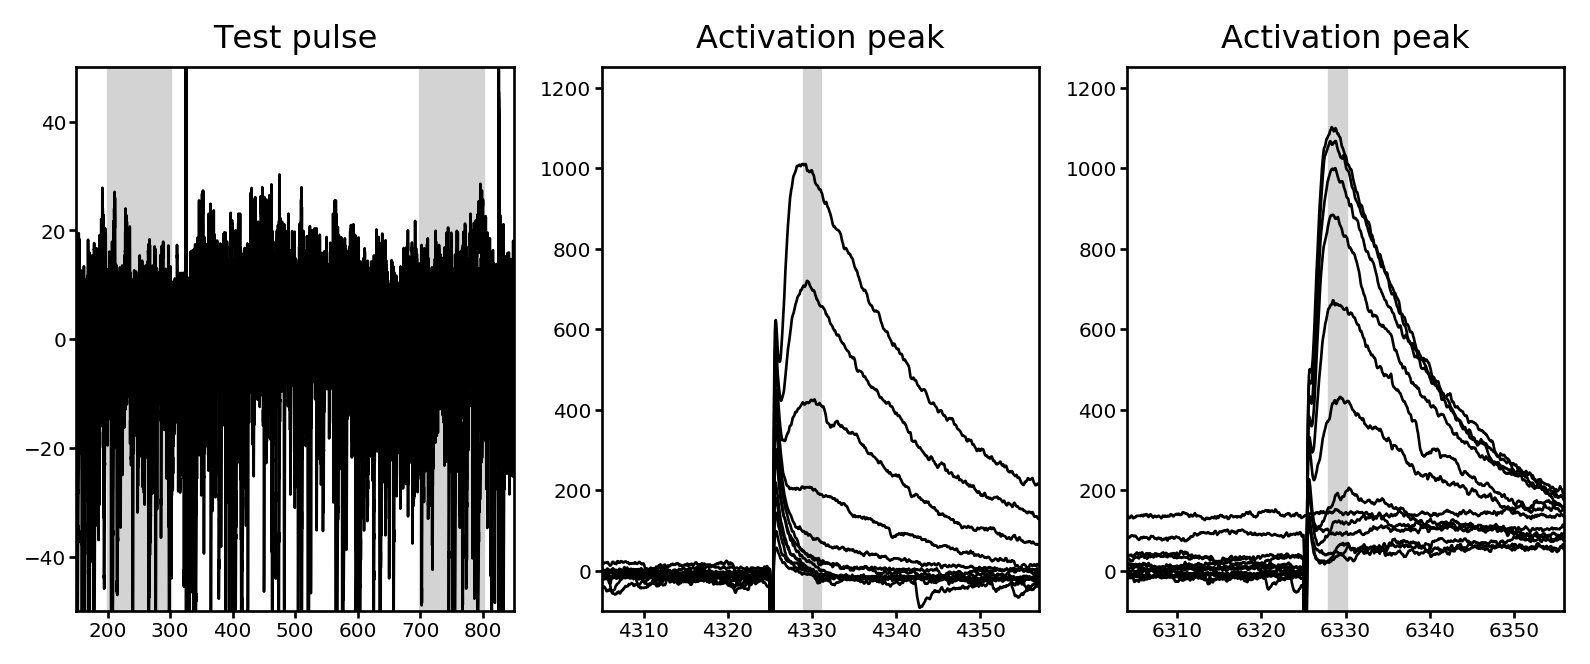

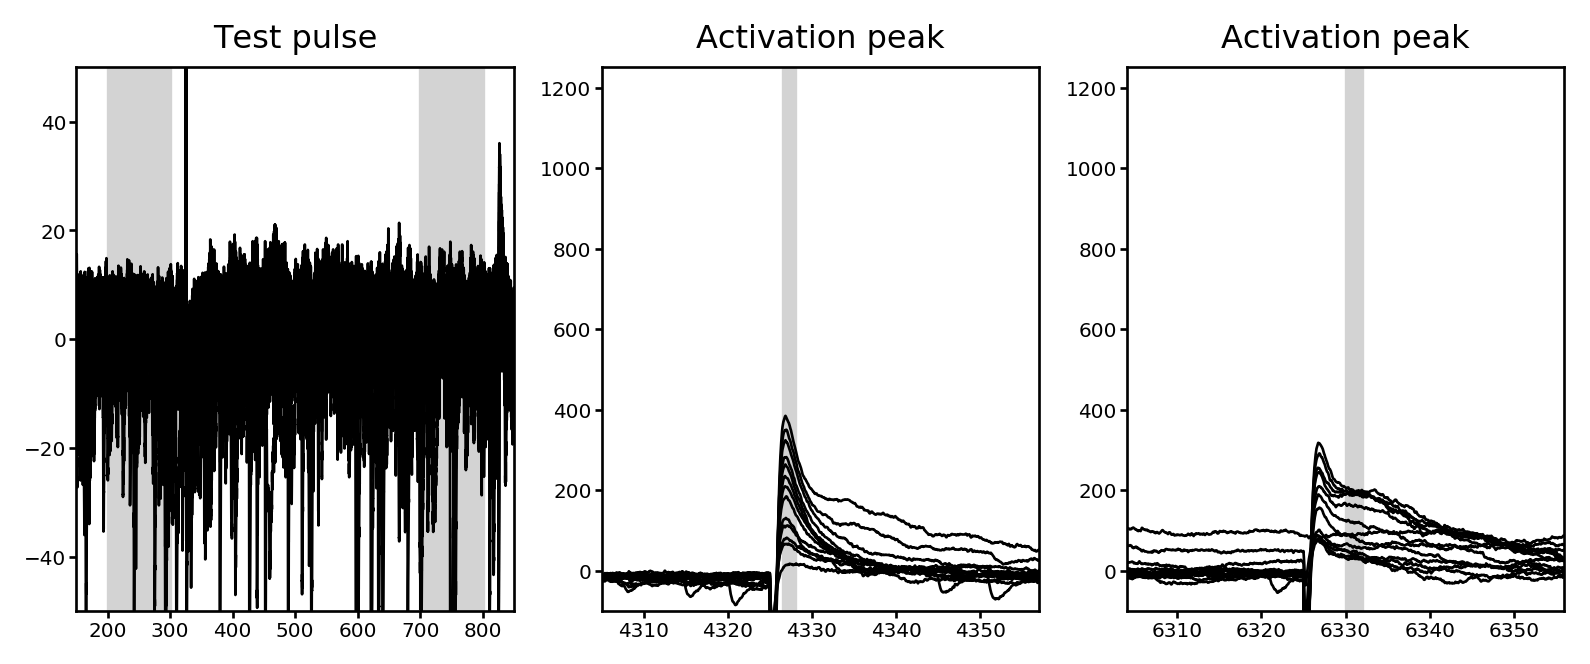

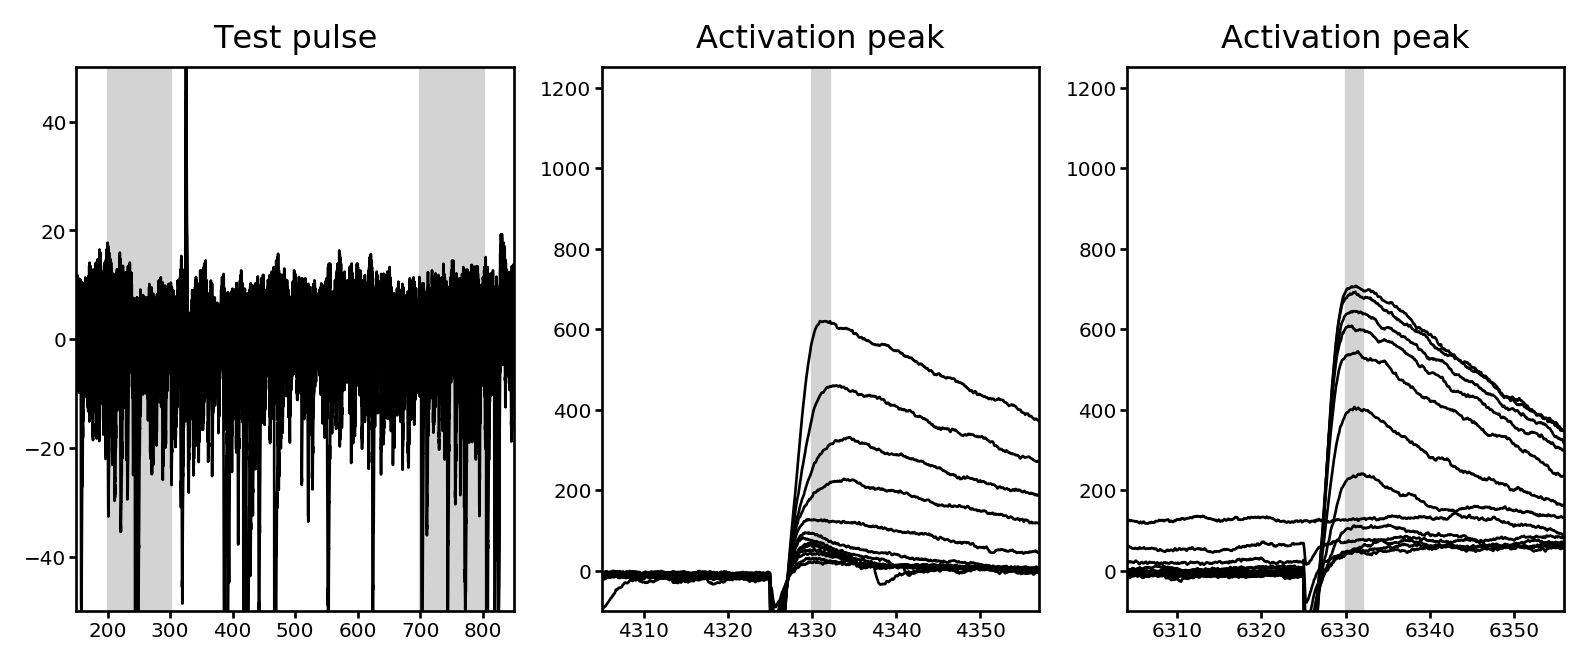

In [11]:
test_pulse_xlim = (
    gating_time_windows['windows']['baseline_window'][0] - 1000,
    gating_time_windows['windows']['test_window'][1] + 1000,
)
activation_xlim = (
    gating_time_windows['windows']['activation_peak_window'][1][0] - 500,
    gating_time_windows['windows']['activation_peak_window'][1][1] + 500,
)

inactivation_xlim = (
    gating_time_windows['windows']['inactivation_peak_window'][1][0] - 500,
    gating_time_windows['windows']['inactivation_peak_window'][1][1] + 500
)


def __plot_processed_current_traces(recording, ax):
    """Dirty helper function to plot traces from the current (I) channel."""
    ax.plot(
        recording.time_supp,
        preprocess_recording(
            recording,
            slice(*gating_time_windows['windows']['baseline_window']),
            slice(*gating_time_windows['windows']['test_window']),
            VOLTAGE_CHANNEL,
            CURRENT_CHANNEL,
        )[CURRENT_CHANNEL, ...],
        'k-'
    )


for i, r in enumerate(gating):
    fig, axes = plt.subplots(1, 3, figsize=(8, 3))

    mgw = partial(
        mark_time_interval,
        time_unit=gating_time_windows['window_unit'],
        dt=r.dt,
        color='lightgray',
    )

    axes[0].set_title('Test pulse')
    mgw(gating_time_windows['windows']['baseline_window'], ax=axes[0])
    mgw(gating_time_windows['windows']['test_window'], ax=axes[0])
    __plot_processed_current_traces(r, axes[0])
    axes[0].set_xlim(np.array(test_pulse_xlim) * r.dt)
    axes[0].set_ylim(-50, 50)

    axes[1].set_title('Activation peak')
    mgw(gating_time_windows['windows']['activation_peak_window'][i], ax=axes[1])
    __plot_processed_current_traces(r, axes[1])
    axes[1].set_xlim(np.array(activation_xlim) * r.dt)
    axes[1].set_ylim(-100, 1250)
    
    axes[2].set_title('Activation peak')
    mgw(gating_time_windows['windows']['inactivation_peak_window'][i], ax=axes[2])
    __plot_processed_current_traces(r, axes[2])
    axes[2].set_xlim(np.array(inactivation_xlim) * r.dt)
    axes[2].set_ylim(-100, 1250)

    plt.show()

In [12]:
pdata = extract_gating_data(
    gating,
    window_unit=gating_time_windows['window_unit'],
    **gating_time_windows['windows']
)

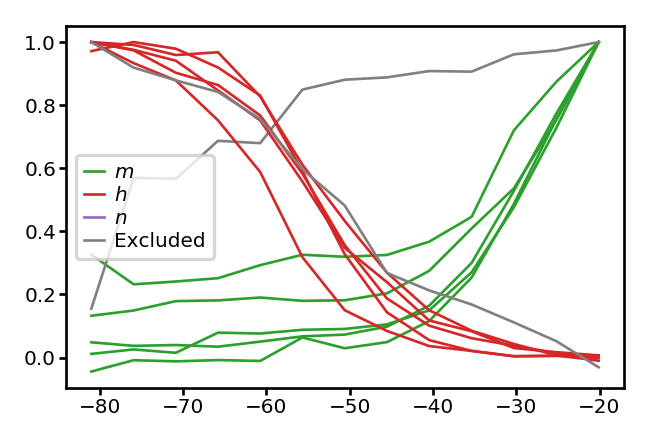

In [13]:
exclude = np.array([False, False, False, False, True, False])

plt.subplot(111)
plt.plot(
    pdata['activation_peak'][1, :, ~exclude].T,
    max_normalize_channel(pdata['activation_peak'][0, :, ~exclude].T),
    color=colors['m'],
    label=r'$m_\infty$',
)
plt.plot(
    pdata['activation_peak'][1, :, exclude].T,
    max_normalize_channel(pdata['activation_peak'][0, :, exclude].T),
    color='gray',
    label=r'$m_\infty$',
)

plt.plot(
    pdata['inactivation_peak'][1, :, ~exclude].T,
    max_normalize_channel(pdata['inactivation_peak'][0, :, ~exclude].T),
    color=colors['h'],
    label=r'$m_\infty$',
)
plt.plot(
    pdata['inactivation_peak'][1, :, exclude].T,
    max_normalize_channel(pdata['inactivation_peak'][0, :, exclude].T),
    color='gray',
    label=r'$m_\infty$',
)
plt.legend(
    [
        Line2D([0], [0], color=colors['m']),
        Line2D([0], [0], color=colors['h']),
        Line2D([0], [0], color=colors['n']),
        Line2D([0], [0], color='gray'),
    ],
    ['$m$', '$h$', '$n$', 'Excluded'],
)

In [14]:
params = {}
fittedpts = {}
initial_param_guess = {
    'activation_peak': [12, 1, -30],
    'inactivation_peak': [12, -1, -60],
    'steady_state': [12, 1, -25],
}

for k, v in pdata.iteritems():
    p, f = fit_gating_curve(v[..., ~exclude], initial_param_guess[k])
    params[k] = p
    fittedpts[k] = f

del k, v, p, f, initial_param_guess

params = pd.DataFrame(
    {
        'm': params['activation_peak'],
        'h': params['inactivation_peak'],
        'n': params['steady_state'],
    },
    index=('A', 'k', 'V_half'),
)

save_gating_params(
    os.path.join(
        os.getenv('DATA_PATH'),
        'processed',
        '5HT',
        'gating_params_heated.csv',
    ),
    params,
    rec_index.query(INCLUSION_QUERY),
    ACCESS_RESISTANCE_CUTOFF,
)

params

# num_cells=6
# access_resistance_cutoff_megaohm=20
# access_resistance_mean_megaohm=13.00
# access_resistance_std_megaohm=5.22
# m="I_A activation gate"
# h="I_A inactivation gate"
# n="Non-inactivating current activation gate"
# A="Sigmoid scaling factor"
# k="Sigmoid slope"
# V_half="Sigmoid location (half-activation voltage in mV)"



,h,m,n
A,1.005724,3577.180047,1.264489
k,-0.165735,0.062911,0.250959
V_half,-54.727535,109.821639,-25.290898


# Gating plot

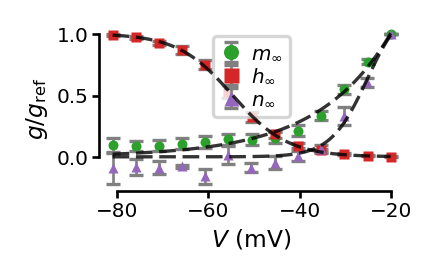

In [15]:
plt_params = {
    'ls': 'none',
    'capsize': 2,
    'ecolor': 'gray',
    'markersize': 3,
    'markeredgecolor': 'none',
}

plt.figure(figsize=(1.7, 1))

plt.errorbar(
    marker='o',
    label='$m_\infty$',
    color=colors['m'],
    **dict(
        plt_params,
        **get_plot_coordinates_with_error(
            pdata['activation_peak'][..., ~exclude]
        )
    )
)
plt.errorbar(
    marker='s',
    label='$h_\infty$',
    color=colors['h'],
    **dict(
        plt_params,
        **get_plot_coordinates_with_error(
            pdata['inactivation_peak'][..., ~exclude]
        )
    )
)
plt.errorbar(
    marker='^',
    label='$n_\infty$',
    color=colors['n'],
    **dict(
        plt_params,
        **get_plot_coordinates_with_error(pdata['steady_state'][..., ~exclude])
    )
)
for key in fittedpts:
    plt.plot(
        fittedpts[key][1, :],
        fittedpts[key][0, :],
        '--',
        color=colors['fit'],
        alpha=0.8,
        lw=1,
        dashes=(5, 2),
        zorder=100,
    )
plt.yticks([0, 0.5, 1])
plt.xlabel('$V$ (mV)')
plt.ylabel(r'$g/g_{\mathrm{ref}}$')
plt.legend(loc='upper center')

sns.despine(trim=True)

plt.subplots_adjust(left=0.2, bottom=0.26, top=0.95, right=0.95)

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'ser_gating_curves_heated'))

In [16]:
params_rt = load_gating_params(
    os.path.join(
        os.getenv('DATA_PATH'), 'processed', '5HT', 'gating_params_room_temp.csv',
    ),
)
params_rt

,h,m,n
A,1.025027,1.612950,1.547850
k,-0.164914,0.098484,0.216088
V_half,-59.193314,-23.675045,-24.303698


In [17]:
from grr.CurveFit import sigmoid_curve, compute_residuals

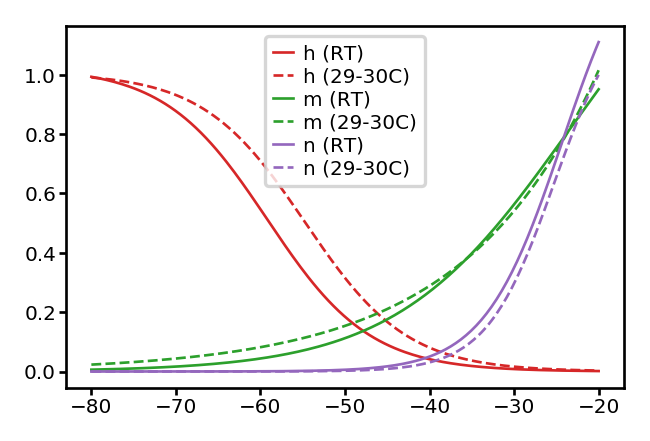

In [18]:
plt.figure()

plt.subplot(111)

x = np.linspace(-80, -20, 200)
for gate in params.columns:
    plt.plot(
        x, sigmoid_curve(params_rt[gate].to_numpy(), x), 
        color=colors[gate], ls='-', label='{} (RT)'.format(gate)
    )
    plt.plot(
        x, sigmoid_curve(params[gate].to_numpy(), x),
        color=colors[gate], ls='--', label='{} (29-30C)'.format(gate)
    )
plt.legend()
plt.show()